# Detection Malicious URL Using ML Models:

## Table of contents 
- **Importing Libraries**
- **Load Dataset**
- **Feature Extraction**
- **Train Test Split**
- **Training models**
- **Predicting new data**

## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import seaborn as sns 
%matplotlib inline

import tldextract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
from urllib.parse import urlparse
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

## Load Dataset

In [2]:
data = pd.read_csv("malicious_phish.csv")

In [3]:
print(data.shape)
data.head()


(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
data.isnull().sum()

url     0
type    0
dtype: int64

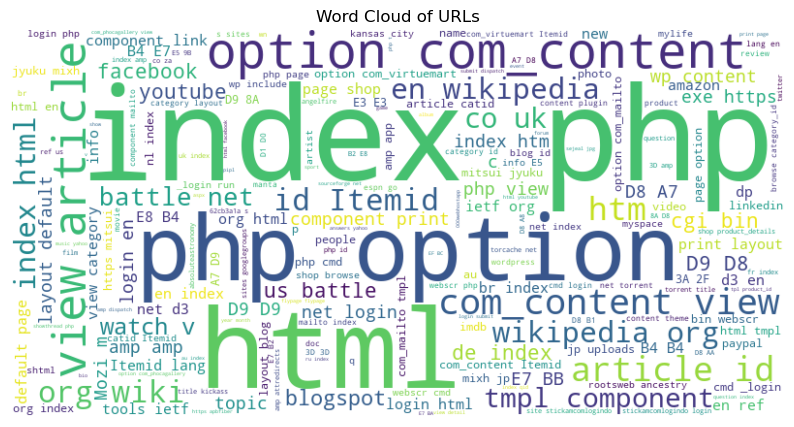

In [6]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['url']))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [7]:
data_benign = data[data.type == 'benign']
data_phish = data[data.type == 'phishing']
data_deface = data[data.type == 'defacement']
data_malware = data[data.type == 'malware']

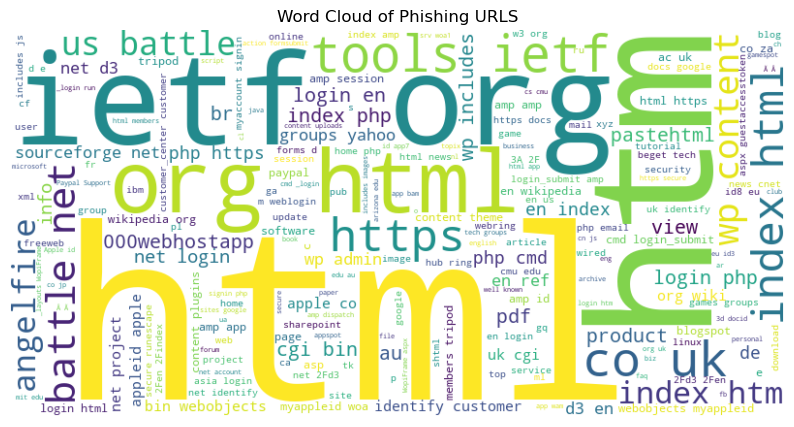

In [8]:
phish_url = " ".join(i for i in data_phish.url)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(phish_url)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing URLS')
plt.show()

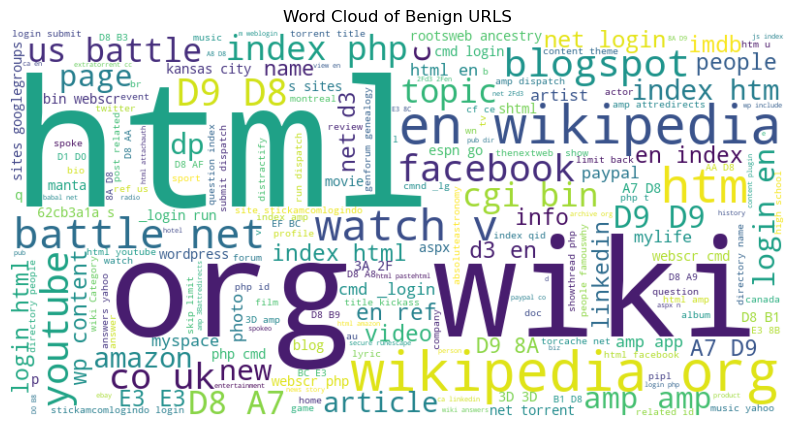

In [9]:
benign_url = " ".join(i for i in data_benign.url)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(benign_url)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Benign URLS')
plt.show()

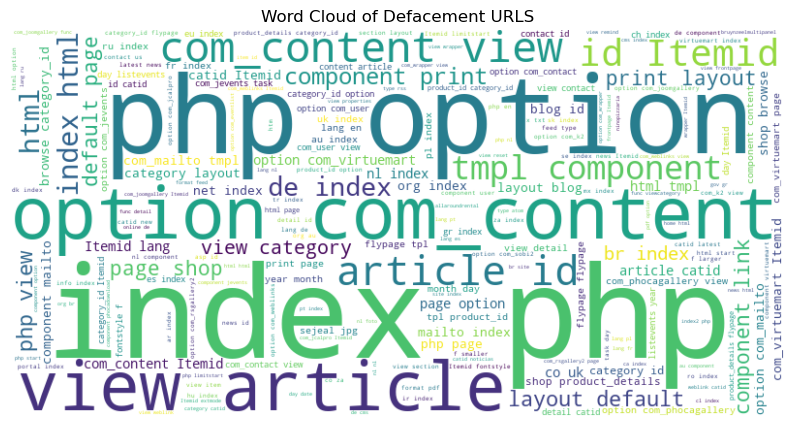

In [10]:
deface_url = " ".join(i for i in data_deface.url)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(deface_url)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Defacement URLS')
plt.show()

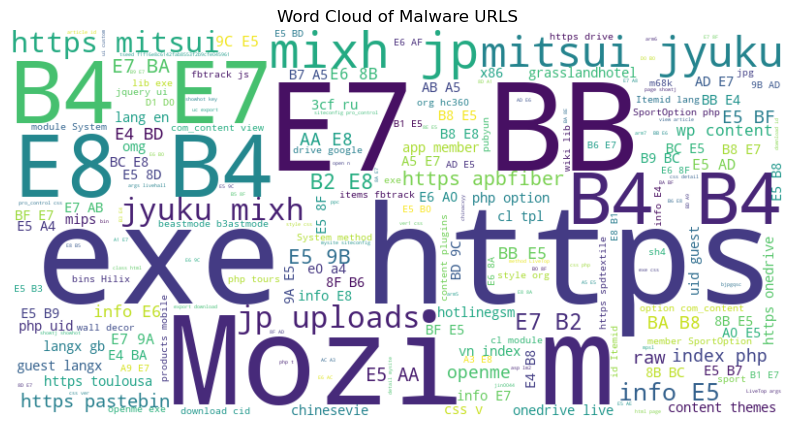

In [11]:
malware_url = " ".join(i for i in data_malware.url)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(malware_url)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Malware URLS')
plt.show()

<Axes: xlabel='type', ylabel='count'>

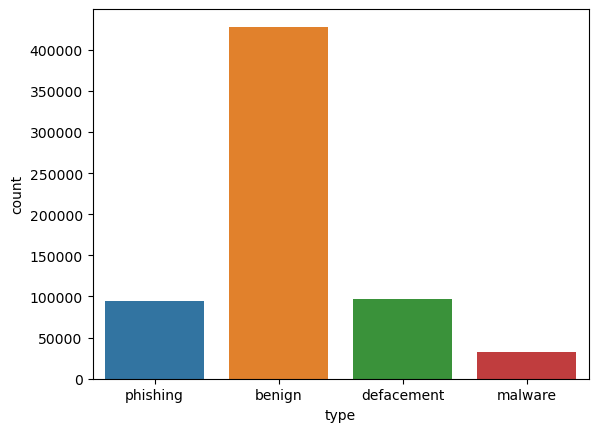

In [12]:
sns.countplot(x = 'type', data = data)

In [13]:
data['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [14]:
data['url'] = data['url'].replace('www.', '', regex=True)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Feature Extraction

In [15]:
def url_type(url):
    url_types = {
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
    }
    if url in url_types:
        return url_types[url]
    else:
        return -1

data["url_type"] = data["type"].apply(lambda x: url_type(x))
data.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [16]:
def url_length(url):
    return len(str(url))

data['url_len'] = data['url'].apply(lambda x: url_length(x))
data.head()

,url,type,url_type,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


In [17]:
def extract_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        domain= res.parsed_url.netloc
    except :
        domain= None
    
    return domain

data['url_domain'] = data['url'].apply(lambda x: extract_domain(x))
data.head()


,url,type,url_type,url_len,url_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [18]:
def count_letters(url):
    num_letters = sum(i.isalpha() for i in url)
    return num_letters

def count_digits(url):
    num_digits = sum(i.isdigit() for i in url)
    return num_digits

def count_special_chars(url):
    special_chars = ['@','?','-','=','.','#','%','+','$','!','*',',','//','&','/','^','()','_','[]','{}',';',':','<>','~']
    num_special_chars = sum(i in special_chars for i in url)
    return num_special_chars

data['letters_count'] = data['url'].apply(lambda x: count_letters(x))
data['digits_count']  = data['url'].apply(lambda x: count_digits(x))
data['special_chars_count']  = data['url'].apply(lambda x: count_special_chars(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14


In [19]:
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))

data['shortened']  =data['url'].apply(lambda x: has_shortening_service(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0


In [20]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0

data['abnormal_url']  =data['url'].apply(lambda x: abnormal_url(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1


In [21]:
def secure_https(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0
    
data['https']  =data['url'].apply(lambda x: secure_https(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0


In [22]:
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0
    
data['have_ip'] = data['url'].apply(lambda x: have_ip_address(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0


In [23]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
      
data['sus_words'] = data['url'].apply(lambda x: suspicious_words(x))
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,0


In [24]:
def tld_length(url):
    try:
        extracted = tldextract.extract(url)
        tld = extracted.suffix
        return len(tld)
    except:
        return 0
    
data['tld_length'] = data['url'].apply(lambda x: tld_length(x))
data.head()  


,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words,tld_length
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,0,6
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,0,3
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,0,3
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,0,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,0,3


In [25]:
data.isnull().sum()

url                        0
type                       0
url_type                   0
url_len                    0
url_domain             12223
letters_count              0
digits_count               0
special_chars_count        0
shortened                  0
abnormal_url               0
https                      0
have_ip                    0
sus_words                  0
tld_length                 0
dtype: int64

In [26]:
data.fillna(0,inplace=True)

In [27]:
data.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
url_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
https                  0
have_ip                0
sus_words              0
tld_length             0
dtype: int64

In [28]:
def domain_length(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        domain= res.parsed_url.netloc
        return len(str(domain))
    except Exception as e:
        return 0

data['domain_length'] = data['url'].apply(lambda x: domain_length(x))
data.head()


,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words,tld_length,domain_length
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,0,6,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,0,3,11
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,0,3,14
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,0,2,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,0,3,23


<Axes: xlabel='type', ylabel='count'>

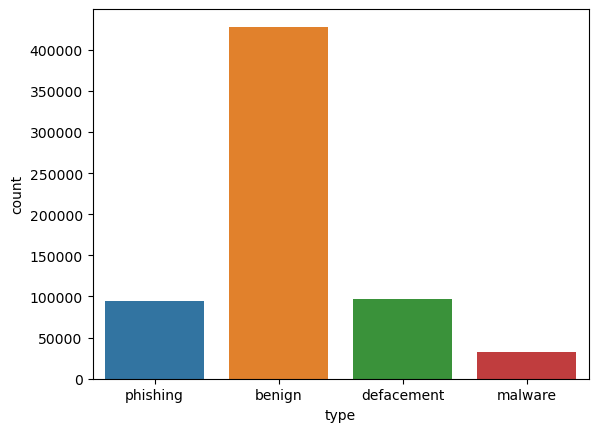

In [29]:
sns.countplot(x = 'type', data = data)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5784\3161155497.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['url_len'].dropna(),kde=False,color='blue',axlabel = "URL Length", label = "Distribution of URL Lengths", bins = 80)


<Axes: xlabel='URL Length'>

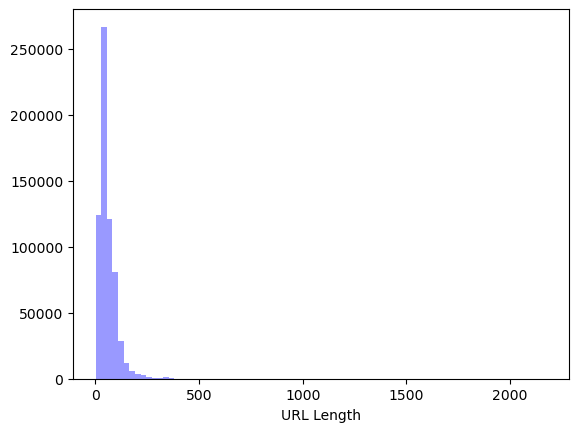

In [30]:
sns.distplot(data['url_len'].dropna(),kde=False,color='blue',axlabel = "URL Length", label = "Distribution of URL Lengths", bins = 80)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5784\1827725405.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['letters_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=100)


<Axes: xlabel='Special Characters Count'>

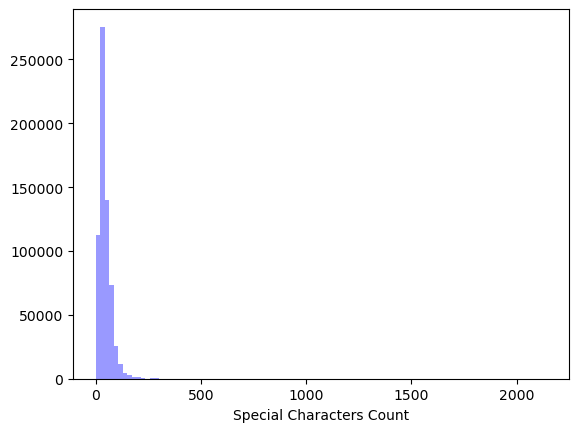

In [31]:
sns.distplot(data['letters_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=100)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5784\1156989370.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['digits_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins = 50)


<Axes: xlabel='Special Characters Count'>

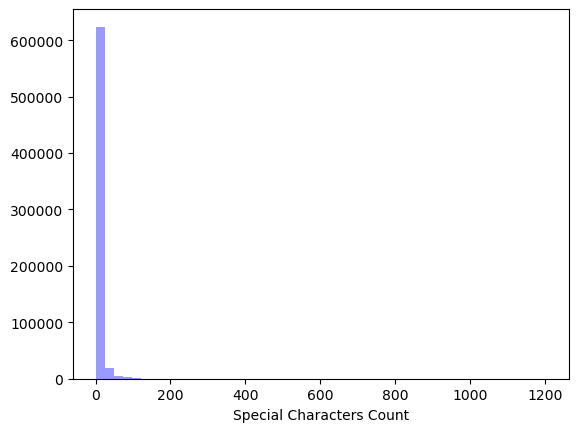

In [32]:
sns.distplot(data['digits_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins = 50)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5784\3161622642.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['special_chars_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=60)


<Axes: xlabel='Special Characters Count'>

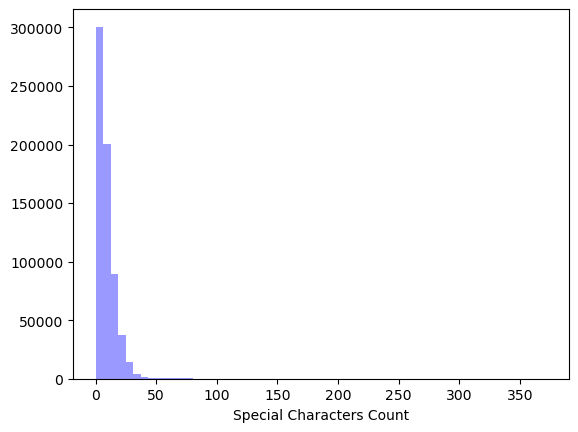

In [33]:
sns.distplot(data['special_chars_count'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=60)

In [34]:
# # Convert url_domain values to strings and filter out None and int values
# filtered_domains = data['url_domain'].map(str).dropna()

# # Concatenate all url_domain values into a single string
# text = ' '.join(filtered_domains)

letters_count          29082844
digits_count            3598210
special_chars_count     5943179
dtype: int64


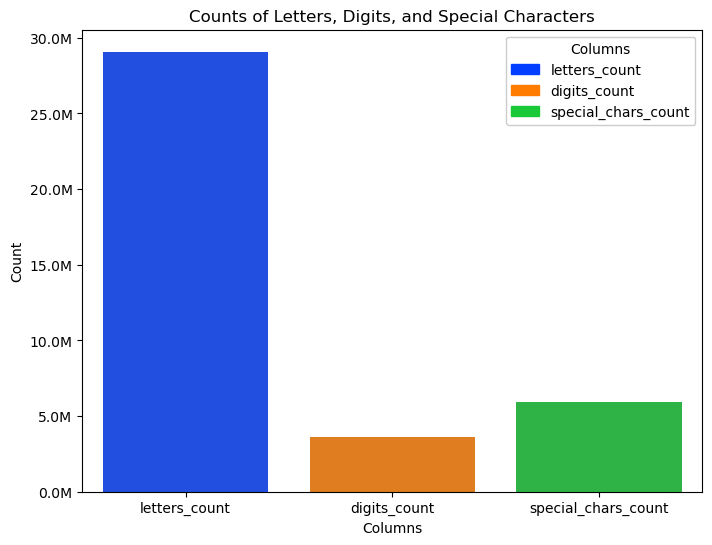

In [35]:
count = data[['letters_count', 'digits_count', 'special_chars_count']]
lds = pd.DataFrame(count)

sums = lds.sum()
print(sums)
plt.figure(figsize=(8, 6))

custom_palette = sns.color_palette('bright', len(sums))

ax = sns.barplot(x=sums.index, y=sums.values, palette = custom_palette)
# ax.set_xticklabels([])
ax.yaxis.set_major_formatter(lambda x, _: f'{x / 1e6:.1f}M')

legend_labels = lds.columns
legend_elements = [Patch(color=color, label=label) for color, label in zip(custom_palette, legend_labels)]
legend = plt.legend(handles = legend_elements, title='Columns', loc='upper right', framealpha=1)
legend.get_title().set_color('black')

plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Counts of Letters, Digits, and Special Characters')
plt.show()

<Axes: xlabel='shortened', ylabel='count'>

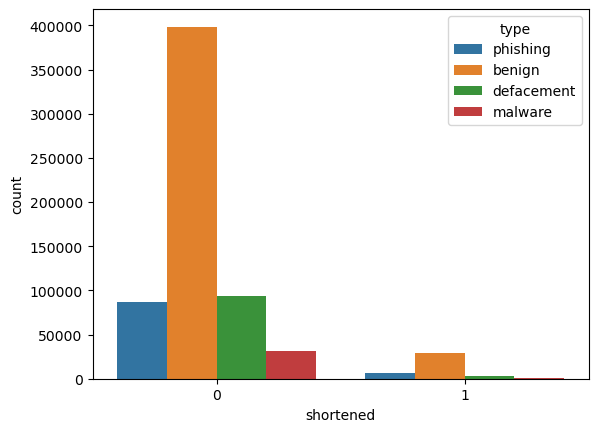

In [36]:
sns.countplot(x='shortened', hue = 'type', data=data)

<Axes: xlabel='abnormal_url', ylabel='count'>

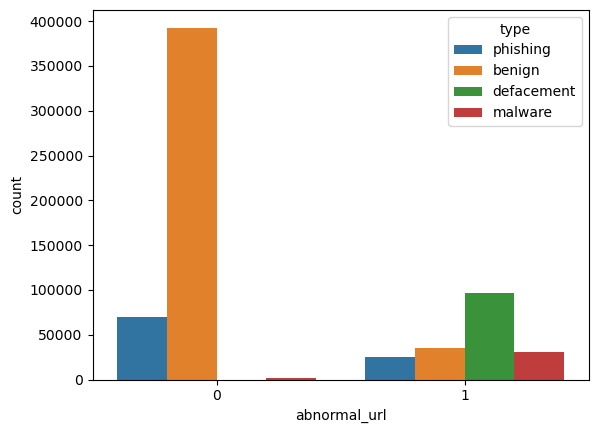

In [37]:
sns.countplot(x = 'abnormal_url', hue = 'type', data = data)

<Axes: xlabel='https', ylabel='count'>

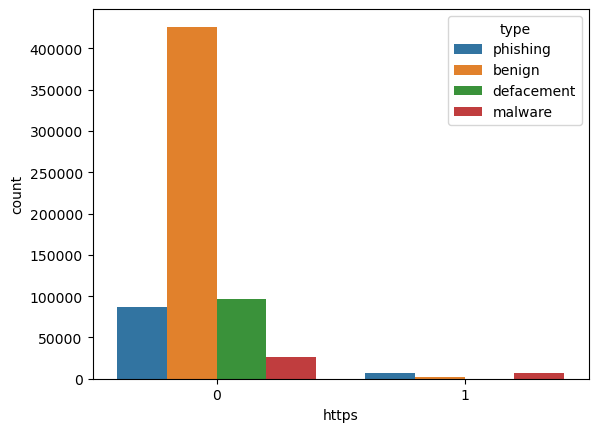

In [38]:
sns.countplot(x = 'https', hue = 'type', data = data)

<Axes: xlabel='have_ip', ylabel='count'>

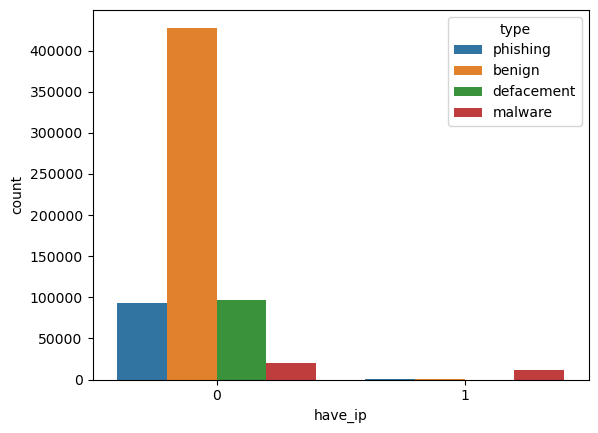

In [39]:
sns.countplot(x = 'have_ip', hue = 'type', data = data)

<Axes: xlabel='sus_words', ylabel='count'>

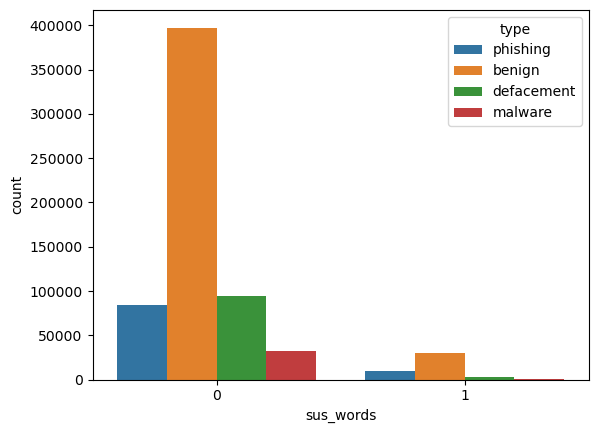

In [40]:
sns.countplot(x = 'sus_words', hue = 'type', data = data)

<Axes: xlabel='tld_length', ylabel='count'>

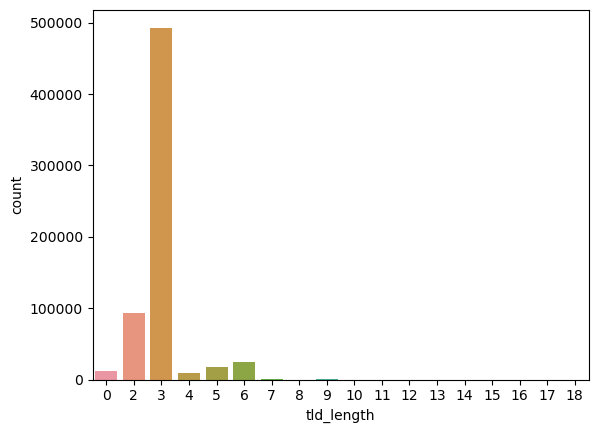

In [41]:
# sns.distplot(data['tld_length'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=60)
sns.countplot(x = 'tld_length', data = data)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5784\3025878168.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['domain_length'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=60)


<Axes: xlabel='Special Characters Count'>

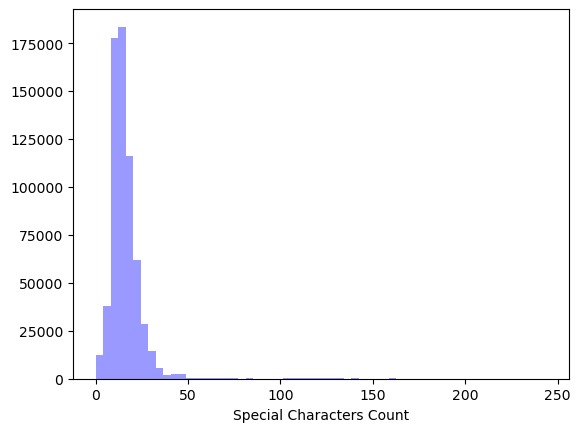

In [42]:
sns.distplot(data['domain_length'].dropna(),kde=False,color='blue',axlabel = "Special Characters Count", label = "Special Characters", bins=60)

In [43]:
data.duplicated().sum()

11081

In [44]:
data.drop_duplicates(inplace=True)

In [45]:
data.columns

Index(['url', 'type', 'url_type', 'url_len', 'url_domain', 'letters_count',
       'digits_count', 'special_chars_count', 'shortened', 'abnormal_url',
       'https', 'have_ip', 'sus_words', 'tld_length', 'domain_length'],
      dtype='object')

In [46]:
data.head()

,url,type,url_type,url_len,url_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words,tld_length,domain_length
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,0,6,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,0,3,11
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,0,3,14
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,60,7,17,0,1,0,0,0,2,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,0,3,23


In [47]:
final_data = data.drop(columns=['url','type','url_domain'])
final_data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words,tld_length,domain_length
0,2,16,13,0,3,0,0,0,0,0,6,16
1,0,35,29,1,5,0,0,0,0,0,3,11
2,0,31,25,1,5,0,0,0,0,0,3,14
3,1,84,60,7,17,0,1,0,0,0,2,17
4,1,235,199,22,14,0,1,0,0,0,3,23


In [59]:
final_data.corr()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,https,have_ip,sus_words,tld_length,domain_length
url_type,1.000000,-0.054037,-0.076986,0.001373,0.001573,-0.031783,0.453458,0.294752,0.381199,-0.006410,-0.156038,-0.056834
url_len,-0.054037,1.000000,0.957229,0.693757,0.818434,0.016777,0.361022,0.075839,-0.067156,0.275421,0.041095,0.287030
letters_count,-0.076986,0.957229,1.000000,0.481221,0.717333,0.023589,0.333731,0.056791,-0.132294,0.265503,0.077598,0.283335
digits_count,0.001373,0.693757,0.481221,1.000000,0.534627,0.000542,0.158833,0.089993,0.099403,0.229408,-0.056628,0.289525
special_chars_count,0.001573,0.818434,0.717333,0.534627,1.000000,0.000502,0.493944,0.073015,0.003250,0.154167,0.007251,0.065102
shortened,-0.031783,0.016777,0.023589,0.000542,0.000502,1.000000,-0.046696,0.021307,-0.035708,-0.001447,0.048760,0.086976
abnormal_url,0.453458,0.361022,0.333731,0.158833,0.493944,-0.046696,1.000000,0.254917,0.222118,-0.009436,-0.108911,-0.082530
https,0.294752,0.075839,0.056791,0.089993,0.073015,0.021307,0.254917,1.000000,-0.017652,0.023328,-0.023805,0.009809
have_ip,0.381199,-0.067156,-0.132294,0.099403,0.003250,-0.035708,0.222118,-0.017652,1.000000,-0.029192,-0.452612,-0.194466
sus_words,-0.006410,0.275421,0.265503,0.229408,0.154167,-0.001447,-0.009436,0.023328,-0.029192,1.000000,0.043106,0.289523


<Axes: >

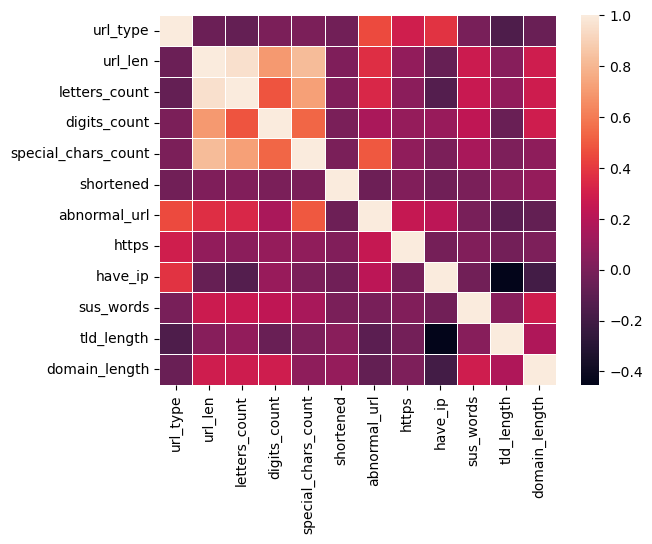

In [57]:
sns.heatmap(final_data.corr(), linewidths=.5)

In [ ]:
data.shape

## Train Test Split

In [60]:
x = final_data.drop(columns=['url_type'])
y = final_data['url_type'] 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [61]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (448077, 11)
Y_train Shape : (448077,)
X_test  Shape : (192033, 11)
Y_test  Shape : (192033,)


## Training Models

In [62]:
"""
# Define classifiers and their corresponding parameters
classifiers = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    KNeighborsClassifier()
]
"""
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
]

Model: DecisionTreeClassifier() 
Test Accuracy :  90.33%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    128361
           1       0.92      0.94      0.93     28496
           2       0.76      0.59      0.67     28136
           3       0.91      0.87      0.89      7040

    accuracy                           0.90    192033
   macro avg       0.88      0.84      0.86    192033
weighted avg       0.90      0.90      0.90    192033

             Confusion_matrix 


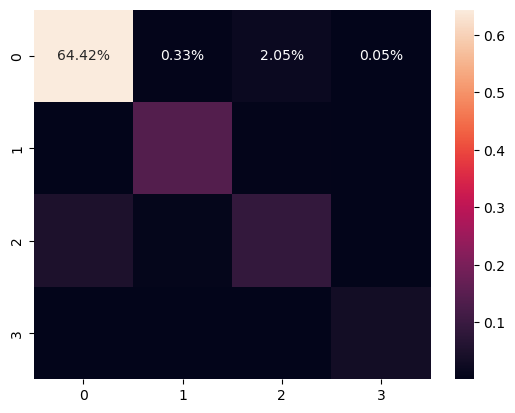

Model: RandomForestClassifier() 
Test Accuracy :  91.18%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95    128361
           1       0.92      0.96      0.94     28496
           2       0.80      0.60      0.69     28136
           3       0.96      0.87      0.91      7040

    accuracy                           0.91    192033
   macro avg       0.90      0.85      0.87    192033
weighted avg       0.91      0.91      0.91    192033

             Confusion_matrix 


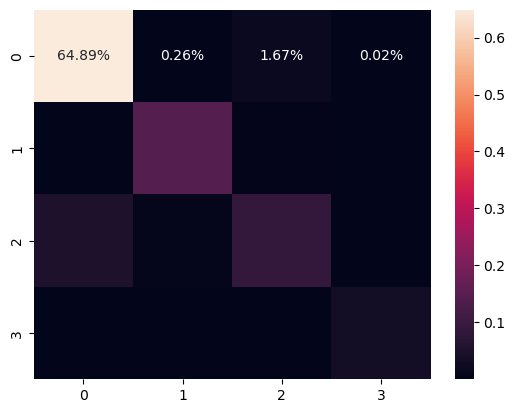

Model: KNeighborsClassifier() 
Test Accuracy :  87.19%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    128361
           1       0.84      0.89      0.87     28496
           2       0.74      0.51      0.61     28136
           3       0.96      0.84      0.89      7040

    accuracy                           0.87    192033
   macro avg       0.86      0.80      0.82    192033
weighted avg       0.87      0.87      0.86    192033

             Confusion_matrix 


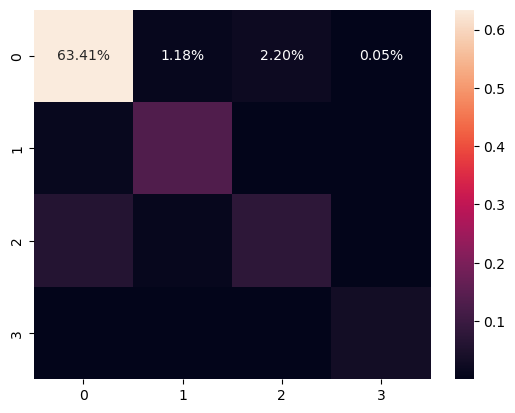

In [63]:
accuracy_test=[]
for m in classifiers:
    
    print('Model:\033[01m {} \033[0m'.format(m))
    model = m
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    accuracy_test.append(acc)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, y_pred))
    print('\033[01m             Confusion_matrix \033[0m')
    plot = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    

Test Accuracy :  91.19%  
              precision    recall  f1-score   support

           0       0.92      0.97      0.95    128361
           1       0.92      0.96      0.94     28496
           2       0.80      0.60      0.69     28136
           3       0.96      0.87      0.91      7040

    accuracy                           0.91    192033
   macro avg       0.90      0.85      0.87    192033
weighted avg       0.91      0.91      0.91    192033



<Axes: >

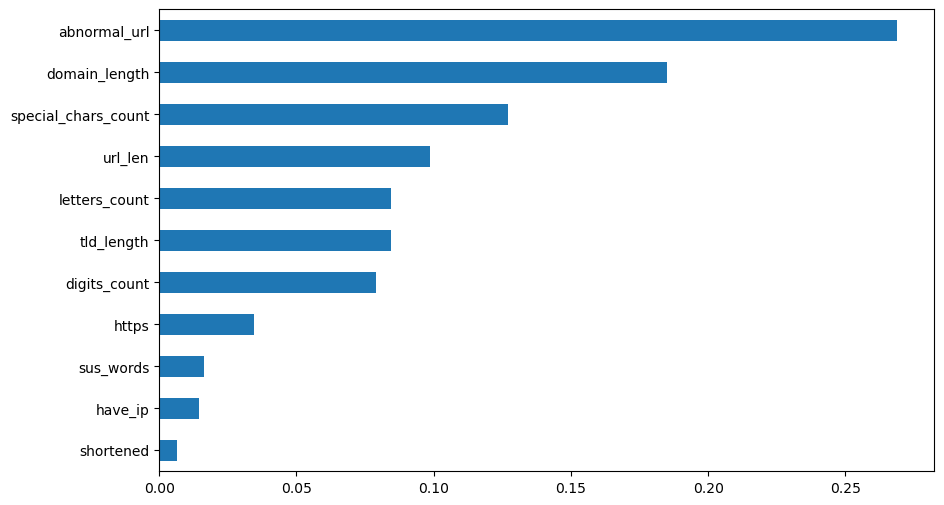

In [64]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
acc = accuracy_score(y_pred, y_test)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print(classification_report(y_test,y_pred))
feat_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))


## Predicting new data

In [65]:
def main(url):
    
    status = []
    
    status.append(url_length(url))
    status.append(count_letters(url))
    status.append(count_digits(url))
    status.append(count_special_chars(url))
    status.append(has_shortening_service(url))
    status.append(abnormal_url(url))
    status.append(secure_https(url)) 
    status.append(have_ip_address(url))
    status.append(suspicious_words(url))
    status.append(tld_length(url))
    status.append(domain_length(url))
    
    return status

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    features_test1 = np.array(features_test).reshape((1, -1))
    pred = rf.predict(features_test1)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res


# Predicting sample raw URLs

urls = ['titaniumcorporate.co.za',
        'en.wikipedia.org/wiki/North_Dakota',
        'http://hollywoodlife.com/2014/05/01/rihanna-iheartradio-music-awards-dress-2014-pics/',
        'sites.google.com/view/ggsipuedc/home',
        'chatgpt.com/',
        'internshala.com/student/personal_details']

for url in urls:
     print("The entered URL is:", get_prediction_from_url(url))

The entered URL is: PHISHING
The entered URL is: SAFE
The entered URL is: SAFE
The entered URL is: SAFE
The entered URL is: SAFE
The entered URL is: SAFE


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:439: Us

In [66]:
import pickle 
pickle.dump(rf, open('randomforest.pkl', 'wb'))